# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval
import scipy

mpl.rcParams['axes.linewidth'] = 2

# Paths

In [2]:
fig5_path = os.getcwd()
figures_path = str(Path(fig5_path).parent)
datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'

# Plot params 

In [3]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject loop 

In [4]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

95 files, 15 folders
14 subjects


In [5]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

## Calculate mean and errorr bars 

In [6]:
alldata_trimed = pd.DataFrame()
alldata = pd.DataFrame(columns=['SUBJECT', 'RUNNING_MEAN'])

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    subjectdata_temp['Running_Mean'] = subjectdata_complete['Running_Mean'].dropna()
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    
    alldata_trimed.loc[row,'SUBJECT'] = subject
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(subjectdata_temp['Running_Mean'])
    
    alldata_trimed.loc[row, 'AVERAGE_MEAN'] = mean
    alldata_trimed.loc[row, 'MEAN_SEM_LOW'] = sem_low
    alldata_trimed.loc[row, 'MEAN_SEM_UP'] = sem_up
    
    if subject == 'S1':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    

    row += 1
    

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


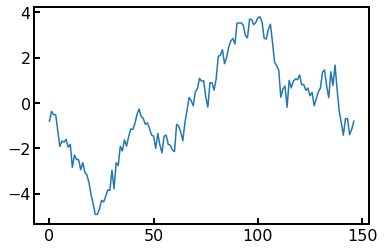

In [7]:
plt.plot(subjectdata_complete['Running_Mean'])

In [8]:
alldata = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    alldata[subject] = subjectdata_complete['Running_Mean'].dropna()
        


S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


In [9]:
for row in range(len(alldata)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata.iloc[row, 0:nSubjects])
    alldata.loc[row, 'MEAN'] = mean
    alldata.loc[row, 'SEM_LOW'] = sem_low
    alldata.loc[row, 'SEM_UP'] = sem_up

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


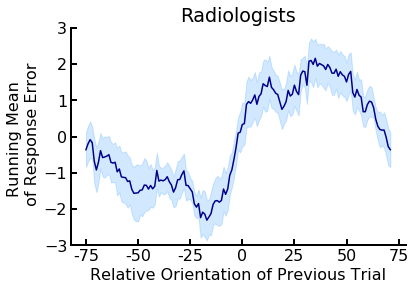

In [10]:
plt.plot(alldata['MEAN'], color='darkblue')
plt.fill_between(range(len(alldata)), alldata['SEM_LOW'], alldata['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Running Mean \n of Response Error')
plt.xlabel('Relative Orientation of Previous Trial')
plt.ylim([-3, 3])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks(np.arange(0, 151, 25), ('-75', '-50', '-25', '0', '25', '50', '75'))
sns.despine()
plt.title('Radiologists')
plt.savefig('AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

# Calculating running mean w/ diff step 

In [6]:
def getRunningMean(stimuli_diff, filtered_responseError, halfway =73, step = 20):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

In [12]:
test = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)

In [13]:
RM, xvals = getRunningMean(test['Stim_diff'], test['responseError'], step = 20)

In [14]:
## IMPORTANT PARAMETERS:
step = 5

alldata_5 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_5[subject] = RM
        
for row in range(len(alldata_5)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_5.iloc[row, 0:nSubjects])
    alldata_5.loc[row, 'MEAN'] = mean
    alldata_5.loc[row, 'SEM_LOW'] = sem_low
    alldata_5.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


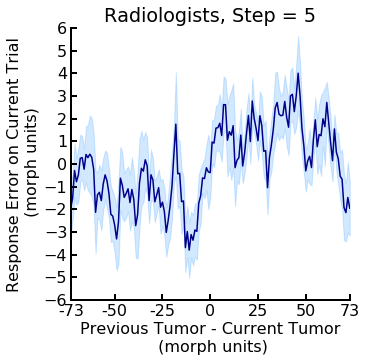

In [15]:
step = 5

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_5['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_5['SEM_LOW'], alldata_5['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-6, 6])
plt.xlim([-73, 73])
plt.yticks(np.arange(-6, 7, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [16]:
## IMPORTANT PARAMETERS:
step = 10

alldata_10 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_10[subject] = RM
        
for row in range(len(alldata_10)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_10.iloc[row, 0:nSubjects])
    alldata_10.loc[row, 'MEAN'] = mean
    alldata_10.loc[row, 'SEM_LOW'] = sem_low
    alldata_10.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


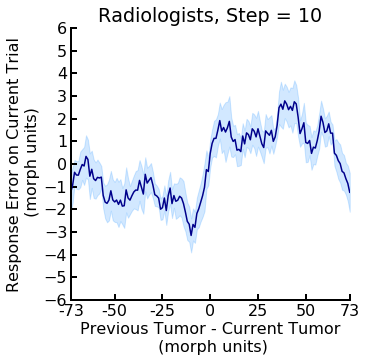

In [17]:
step = 10

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_10['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_10['SEM_LOW'], alldata_10['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-6, 6])
plt.xlim([-73, 73])
plt.yticks(np.arange(-6, 7, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [18]:
## IMPORTANT PARAMETERS:
step = 20

alldata_20 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_20[subject] = RM
        
for row in range(len(alldata_20)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_20.iloc[row, 0:nSubjects])
    alldata_20.loc[row, 'MEAN'] = mean
    alldata_20.loc[row, 'SEM_LOW'] = sem_low
    alldata_20.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


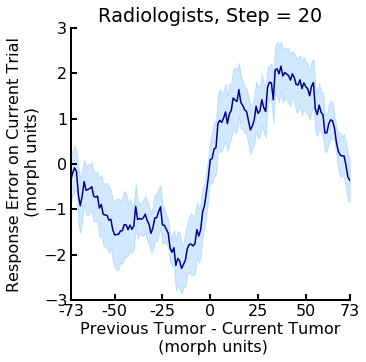

In [19]:
step = 20

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_20['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_20['SEM_LOW'], alldata_20['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [20]:
## IMPORTANT PARAMETERS:
step = 25

alldata_25 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_25[subject] = RM
        
for row in range(len(alldata_25)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_25.iloc[row, 0:nSubjects])
    alldata_25.loc[row, 'MEAN'] = mean
    alldata_25.loc[row, 'SEM_LOW'] = sem_low
    alldata_25.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


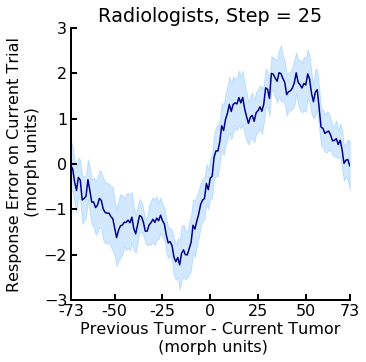

In [21]:
step = 25

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_25['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_25['SEM_LOW'], alldata_25['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [7]:
## IMPORTANT PARAMETERS:
step = 30

alldata_30 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_30[subject] = RM
        
for row in range(len(alldata_30)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_30.iloc[row, 0:nSubjects])
    alldata_30.loc[row, 'MEAN'] = mean
    alldata_30.loc[row, 'SEM_LOW'] = sem_low
    alldata_30.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


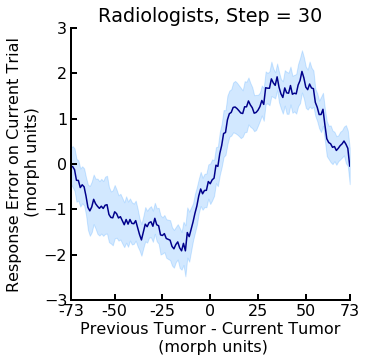

In [8]:
step = 30

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

In [24]:
## IMPORTANT PARAMETERS:
step = 35

alldata_35 = pd.DataFrame()

row = 0
for subject in subject_names:
    print(subject)

    subjectdata_temp = pd.DataFrame()
    
    # load data:
    subjectdata_complete = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    filtered_data = subjectdata_complete[['Stim_diff', 'responseError']].dropna().reset_index(drop=True)
    
    RM, xvals = getRunningMean(filtered_data['Stim_diff'], filtered_data['responseError'], halfway=73, step = step)
    
    alldata_35[subject] = RM
        
for row in range(len(alldata_35)): # let's go calculating row by row
    
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(alldata_35.iloc[row, 0:nSubjects])
    alldata_35.loc[row, 'MEAN'] = mean
    alldata_35.loc[row, 'SEM_LOW'] = sem_low
    alldata_35.loc[row, 'SEM_UP'] = sem_up

S1
S3
S4
S6
S7
S8
s9
s10
s11
s12
s13
s14
s15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


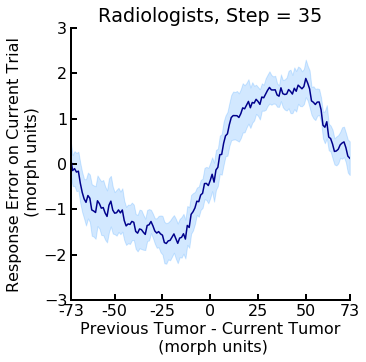

In [25]:
step = 35

plt.figure(figsize=(5, 5))
plt.plot(xvals,alldata_35['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_35['SEM_LOW'], alldata_35['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)
plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists.svg', bbox_inches='tight', dpi=1200)

# Overlay average fit 

In [26]:
fitting_all_data = pd.DataFrame()
for subject in subject_names:
    subjectdata_nonan = pd.DataFrame()
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    
    fitting_all_data[subject] = subjectdata['DoVM'].dropna()


In [27]:
for row in range(len(fitting_all_data)): # let's go calculating row by row
    mean, sem_low, sem_up = mean_confidence_interval.mean_sem(fitting_all_data.iloc[row, 0:nSubjects])
    fitting_all_data.loc[row, 'MEAN'] = mean
    fitting_all_data.loc[row, 'SEM_LOW'] = sem_low
    fitting_all_data.loc[row, 'SEM_UP'] = sem_up

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

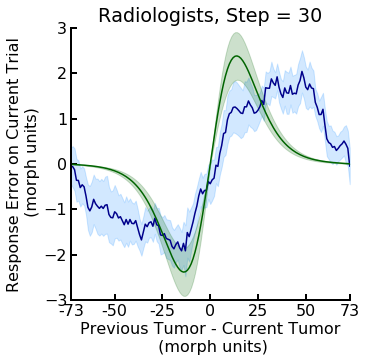

In [28]:
step = 30

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='darkblue')
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='dodgerblue', alpha=0.2)


# fit
plt.plot(range(-73, 74), fitting_all_data['MEAN'], color='darkgreen')
plt.fill_between(range(-73, 74), fitting_all_data['SEM_LOW'], fitting_all_data['SEM_UP'], facecolor="orange", color='darkgreen', alpha=0.2)



plt.ylabel('Response Error on Current Trial\n (morph units)')
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists, Step = ' + str(step))
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wFit2.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wFit2.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wFit2.svg', bbox_inches='tight', dpi=1200)

## New fit 

In [29]:
datapath_newfit = figures_path + '/data/radiologists/Analysis5_27_2020/'
newfit = pd.read_csv(datapath_newfit + 'Radiologist_AverageFit_Output.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


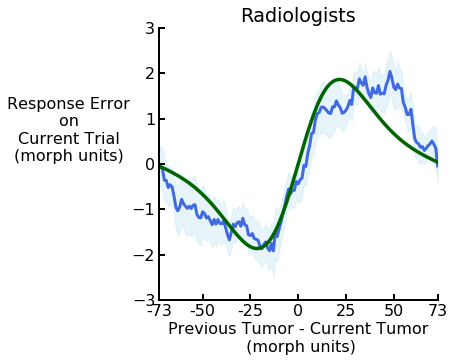

In [30]:
step = 30

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='royalblue', linewidth=3)
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='skyblue', alpha=0.2)


# fit
plt.plot(range(-73, 74), newfit['DoVM'], color='darkgreen', linewidth=3.5)



plt.ylabel('Response Error                       \non                       \nCurrent Trial                       \n(morph units)                       ', rotation=0)
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists')
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wFit3.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wFit3.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wFit3.svg', bbox_inches='tight', dpi=1200)

# Overlay average slope

In [9]:
fitting_all_data_slope = pd.DataFrame()
fitting_all_data_intrcpt = pd.DataFrame()

for subject in subject_names:
    subjectdata_nonan = pd.DataFrame()
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    

    # select the columns we care about
    # drop the NaNs
    
    subjectdata_nonan['slopes'] = subjectdata['slopes'].dropna()
    subjectdata_nonan['intercepts'] = subjectdata['intercepts'].dropna()
    
    fitting_all_data_slope[subject] = subjectdata_nonan['slopes']
    fitting_all_data_intrcpt[subject] = subjectdata_nonan['intercepts']


In [10]:
for row in range(len(fitting_all_data_slope)): # let's go calculating row by row
    mean = np.mean(fitting_all_data_slope.iloc[row, 1:nSubjects])
    fitting_all_data_slope.loc[row, 'MEAN'] = mean
    
for row in range(len(fitting_all_data_intrcpt)): # let's go calculating row by row
    mean = np.mean(fitting_all_data_intrcpt.iloc[row, 1:nSubjects])
    fitting_all_data_intrcpt.loc[row, 'MEAN'] = mean
    
mean_slope, ci_low_slope, ci_up_slope = mean_confidence_interval.confidence_interval_percentile(fitting_all_data_slope['MEAN'])
mean_intercept, ci_low_intercept, ci_up_intercept = mean_confidence_interval.confidence_interval_percentile(fitting_all_data_intrcpt['MEAN'])

# plt.plot(subjectdata_nonan['Stim_diff'], slope*subjectdata_nonan['Stim_diff'] + intercept)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

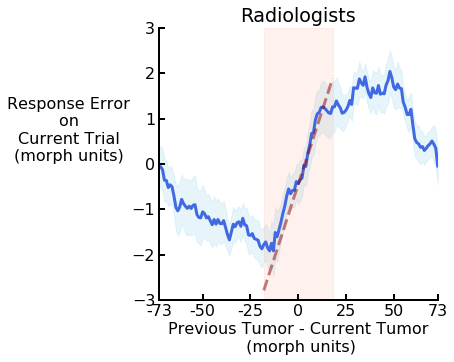

In [11]:

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='royalblue', linewidth=3)
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='skyblue', alpha=0.2)


# fit
plt.plot(np.arange(-18, 19, 1), mean_slope*np.arange(-18, 19, 1)+mean_intercept, color='darkred', linestyle='--', linewidth=3, alpha=0.5)
# plt.fill_between(np.arange(-19, 20, 1), ci_low_slope*+ci_low_intercept, ci_up_slope*np.arange(-19, 20, 1)+ci_up_intercept, facecolor="orange", color='yellow', alpha=0.2)

# yellow squares
plt.axvspan(-18, 18, alpha=0.1, color='coral')



plt.ylabel('Response Error                       \non                       \nCurrent Trial                       \n(morph units)                       ', rotation=0)
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists')
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wSlope.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wSlope.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wSlope.svg', bbox_inches='tight', dpi=1200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


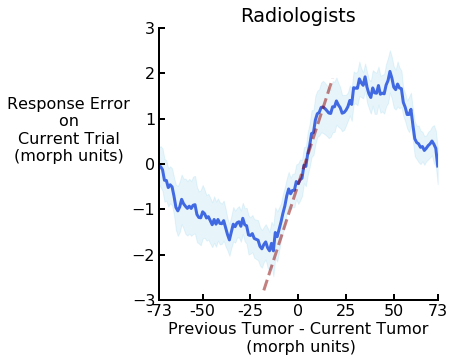

In [12]:

plt.figure(figsize=(5, 5))
plt.plot(xvals, alldata_30['MEAN'], color='royalblue', linewidth=3)
plt.fill_between(xvals, alldata_30['SEM_LOW'], alldata_30['SEM_UP'], facecolor="orange", color='skyblue', alpha=0.2)


# fit
plt.plot(np.arange(-18, 19, 1), mean_slope*np.arange(-18, 19, 1)+mean_intercept, color='darkred', linestyle='--', linewidth=3, alpha=0.5)
# plt.fill_between(np.arange(-19, 20, 1), ci_low_slope*+ci_low_intercept, ci_up_slope*np.arange(-19, 20, 1)+ci_up_intercept, facecolor="orange", color='yellow', alpha=0.2)

# yellow squares
# plt.axvspan(-18, 18, alpha=0.1, color='coral')



plt.ylabel('Response Error                       \non                       \nCurrent Trial                       \n(morph units)                       ', rotation=0)
plt.xlabel('Previous Tumor - Current Tumor\n (morph units)')
plt.ylim([-3, 3])
plt.xlim([-73, 73])
plt.yticks(np.arange(-3, 4, 1))
plt.xticks([-73, -50, -25, 0, 25, 50, 73], ('-73', '-50', '-25', '0', '25', '50', '73'))
sns.despine()
plt.title('Radiologists')
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wSlope2.eps', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wSlope2.jpg', bbox_inches='tight', dpi=1200)
plt.savefig('Step' + str(step) + '_AvgRunningMean_Radiologists_wSlope2.svg', bbox_inches='tight', dpi=1200)